In [1]:
!pip install pandas numpy scikit-learn seaborn matplotlib scipy imbalanced-learn lightgbm catboost xgboost optuna

### Загрузка данных

In [88]:
# Загружаем библиотеки
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import optuna
import matplotlib.pyplot as plt
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import optuna
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier

In [89]:
# Загрузка данных
train = pd.read_csv('dataset/train.csv', index_col='id')
test = pd.read_csv('dataset/test.csv', index_col='id')

In [90]:
# Просмотр первых значений
train.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
id,,,,,,,,,,,,,,,,,,,,,
0,1,1,1,9238,1,1,126.0,1,1,19,...,0,6,7,6,12.428571,0,11.1,0.6,2.02,Graduate
1,1,17,1,9238,1,1,125.0,1,19,19,...,0,6,9,0,0.000000,0,11.1,0.6,2.02,Dropout
2,1,17,2,9254,1,1,137.0,1,3,19,...,0,6,0,0,0.000000,0,16.2,0.3,-0.92,Dropout
3,1,1,3,9500,1,1,131.0,1,19,3,...,0,8,11,7,12.820000,0,11.1,0.6,2.02,Enrolled
4,1,1,2,9500,1,1,132.0,1,19,37,...,0,7,12,6,12.933333,0,7.6,2.6,0.32,Graduate


In [91]:
# Просмотр первых значений целевой переменной
train['Target'].head()

id
0    Graduate
1     Dropout
2     Dropout
3    Enrolled
4    Graduate
Name: Target, dtype: object

### Определение катеогориальных и числовых признаков

In [92]:
# Определение категориальных и числовых признаков
categorical_columns = [
    "Marital status", "Application mode", "Application order", "Course",
    "Daytime/evening attendance", "Previous qualification", "Nacionality",
    "Mother's qualification", "Father's qualification", "Mother's occupation",
    "Father's occupation", "Displaced", "Educational special needs", "Debtor",
    "Tuition fees up to date", "Gender", "Scholarship holder", "International"
]

cat_features = [train.columns.get_loc(col) for col in categorical_columns]

numerical_columns = [
    "Previous qualification (grade)", "Admission grade", "Age at enrollment",
    "Curricular units 1st sem (credited)", "Curricular units 1st sem (enrolled)",
    "Curricular units 1st sem (evaluations)", "Curricular units 1st sem (approved)",
    "Curricular units 1st sem (grade)", "Curricular units 1st sem (without evaluations)",
    "Curricular units 2nd sem (credited)", "Curricular units 2nd sem (enrolled)",
    "Curricular units 2nd sem (evaluations)", "Curricular units 2nd sem (approved)",
    "Curricular units 2nd sem (grade)", "Curricular units 2nd sem (without evaluations)",
    "Unemployment rate", "Inflation rate", "GDP"
]

### Корреляция признаков

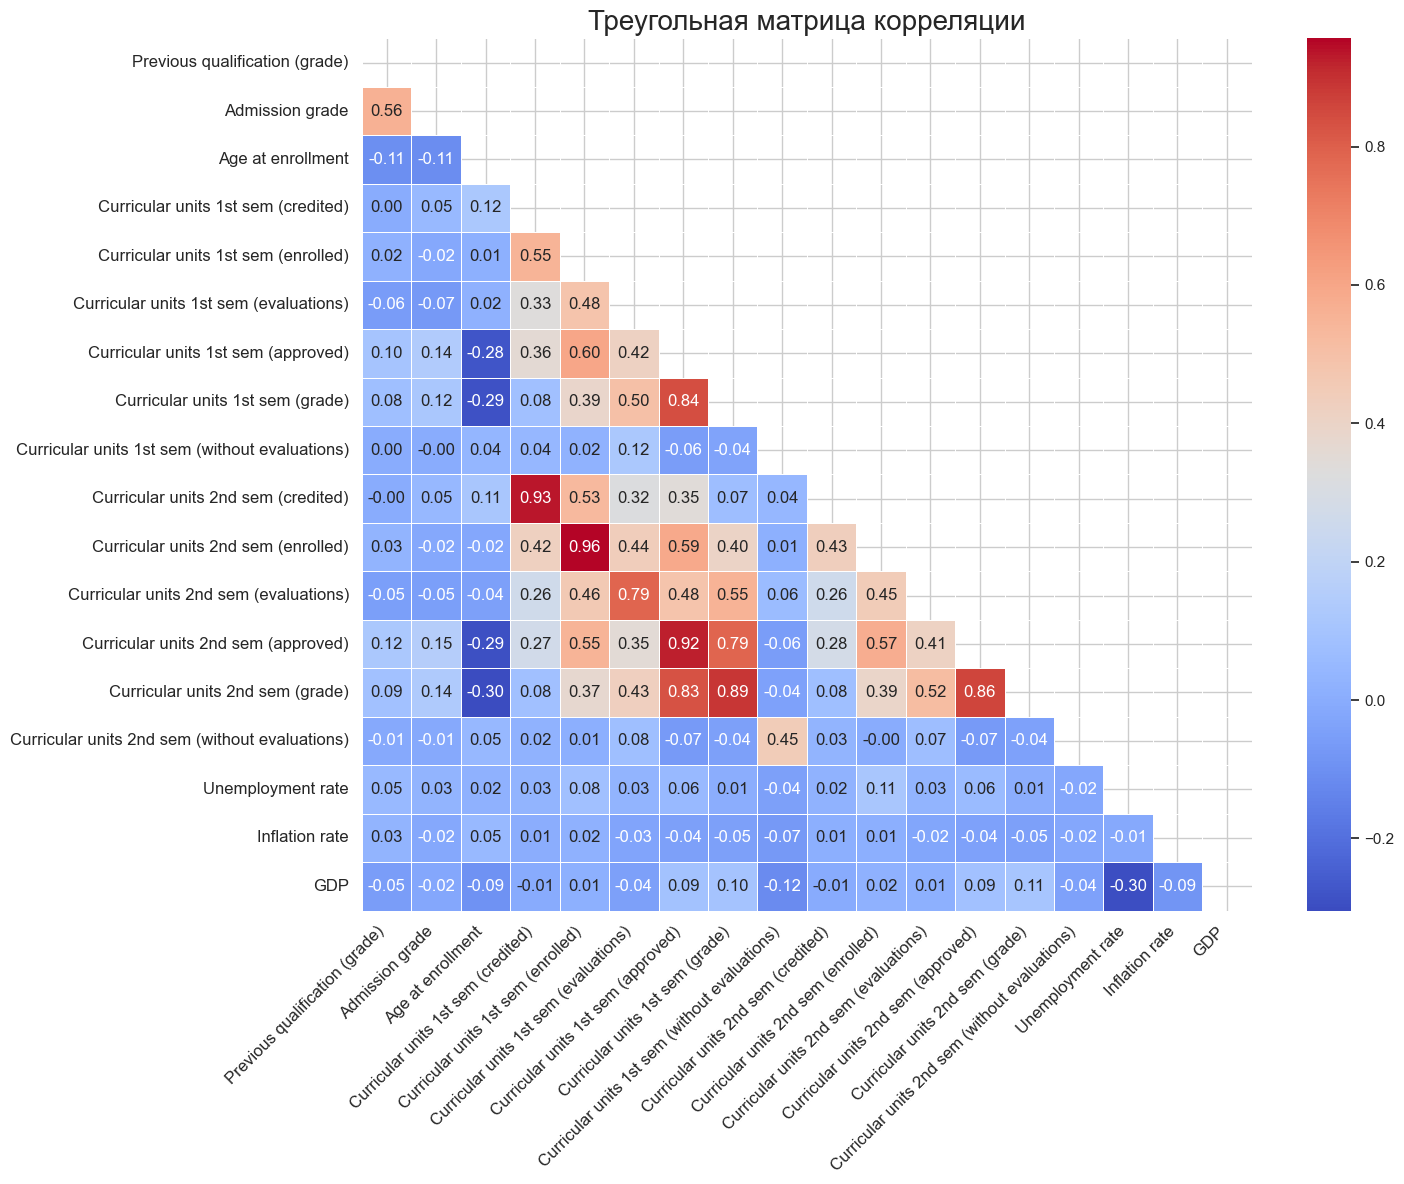

In [93]:
# Вычисляем корреляционную матрицу
corr_matrix = train[numerical_columns].corr()

# Создаем маску для верхней части матрицы
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Настраиваем размер графика
plt.figure(figsize=(15, 12))

# Создаем тепловую карту с маской
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', fmt=".2f", 
            linewidths=0.5, linecolor='white', annot_kws={"size": 12})  # Увеличиваем размер аннотаций

# Добавляем заголовок и настраиваем макет
plt.title('Треугольная матрица корреляции', fontsize=20)

# Настраиваем метки осей
plt.xticks(rotation=45, ha='right', fontsize=12)  # Угол поворота меток по оси X и размер шрифта
plt.yticks(fontsize=12)  # Размер шрифта для меток по оси Y

plt.tight_layout()

# Сохраняем изображение с высоким разрешением
plt.savefig("triangular_correlation.png", dpi=300)
plt.show()

### Кодирование целевой переменной
В результате получаем 3 класса

In [94]:
# Кодирование целевой переменной
le = LabelEncoder()
train['Target'] = le.fit_transform(train['Target'])

# Просмотр уникальных значений после преобразования
unique_values = sorted(zip(le.transform(le.classes_), le.classes_))
print("Преобразованные значения 'Target':", train['Target'].unique(), le.classes_)

Преобразованные значения 'Target': [2 0 1] ['Dropout' 'Enrolled' 'Graduate']


### Нормализация числовых признаков

In [95]:
# Нормализация числовых признаков
scaler = MinMaxScaler(feature_range=(0, 1))
train[numerical_columns] = scaler.fit_transform(train[numerical_columns])

# Проверка результата нормализации
train.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
id,,,,,,,,,,,,,,,,,,,,,
0,1,1,1,9238,1,1,0.326316,1,1,19,...,0.0,0.260870,0.212121,0.30,0.690476,0.0,0.406977,0.311111,0.803170,2
1,1,17,1,9238,1,1,0.315789,1,19,19,...,0.0,0.260870,0.272727,0.00,0.000000,0.0,0.406977,0.311111,0.803170,0
2,1,17,2,9254,1,1,0.442105,1,3,19,...,0.0,0.260870,0.000000,0.00,0.000000,0.0,1.000000,0.244444,0.414795,0
3,1,1,3,9500,1,1,0.378947,1,19,3,...,0.0,0.347826,0.333333,0.35,0.712222,0.0,0.406977,0.311111,0.803170,1
4,1,1,2,9500,1,1,0.389474,1,19,37,...,0.0,0.304348,0.363636,0.30,0.718519,0.0,0.000000,0.755556,0.578600,2


### Анализ выбросов

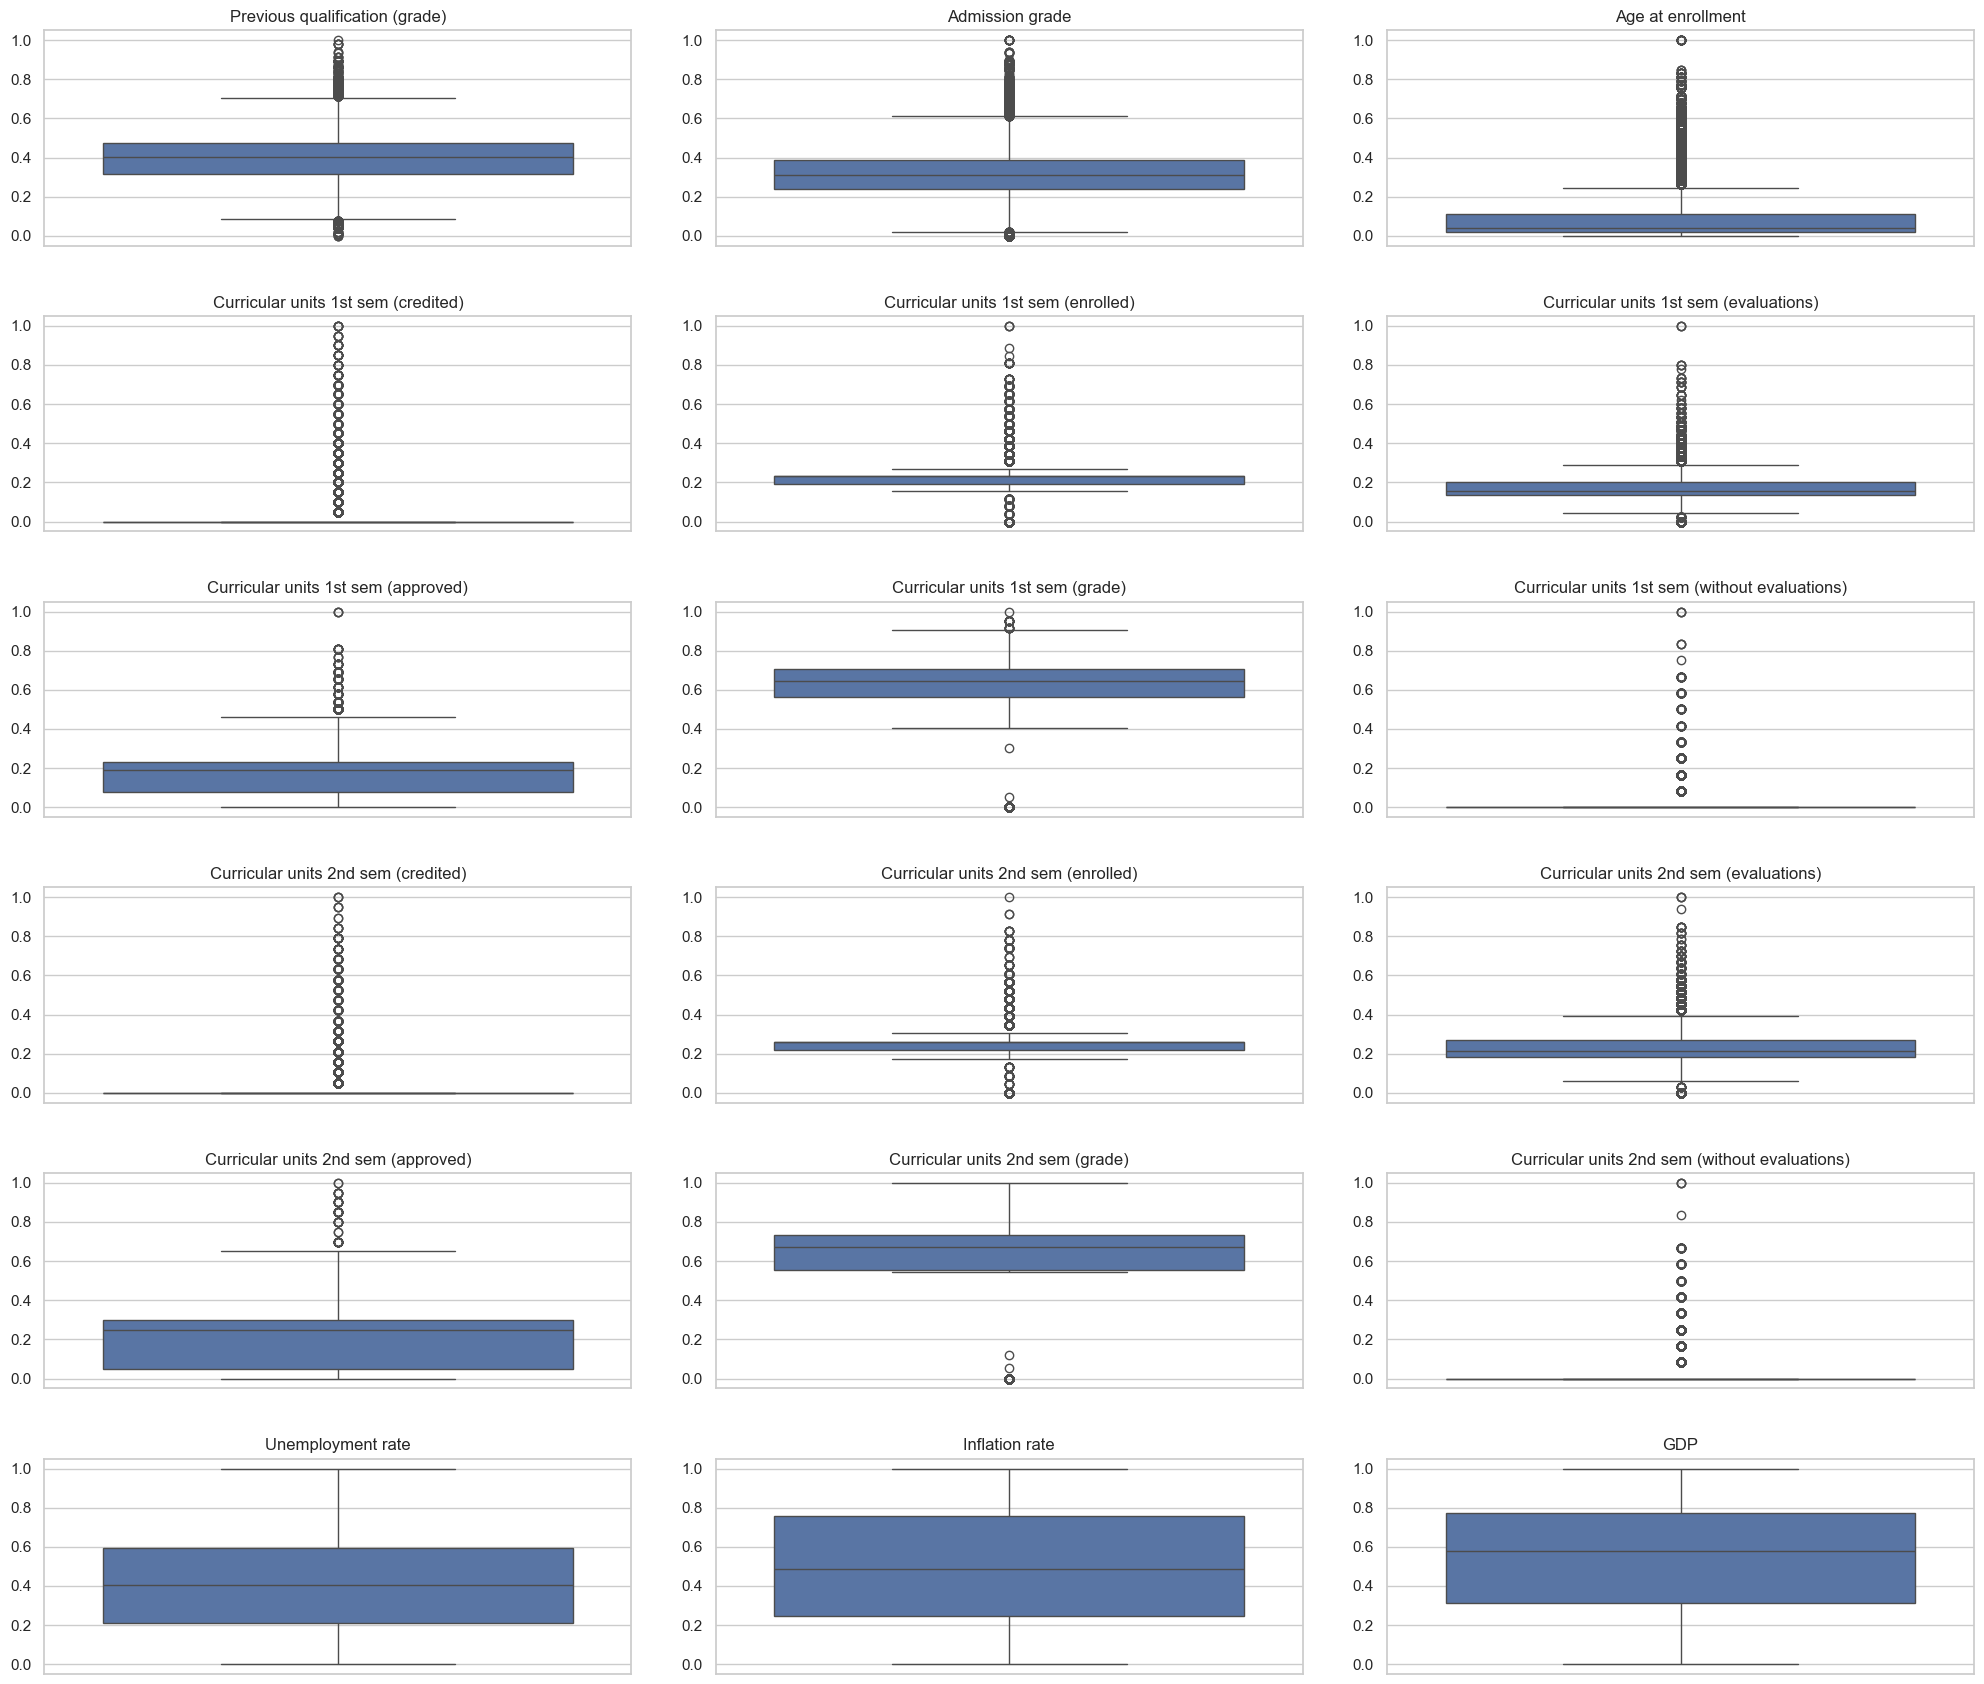

In [96]:
# Настройка стиля графиков
sns.set(style="whitegrid")

num_features = len(numerical_columns)
cols = 3
rows = (num_features + cols - 1) // cols

# Создание ящиков с усами для каждого признака
plt.figure(figsize=(20, 17))
for i, column in enumerate(numerical_columns):
    plt.subplot(rows, cols, i + 1)  # Настройте количество строк и столбцов в зависимости от количества признаков
    sns.boxplot(y=train[column])
    plt.title(column)
    plt.ylabel('')

plt.tight_layout(pad=1.08, h_pad=3, w_pad=3)
plt.show()

In [97]:
# Используем метод межквартильного размаха (IQR) для выявления выбросов
# Выбросы определяются как значения, находящиеся за пределами диапазона Q1 - 1.5 * IQR и Q3 + 1.5 * IQR

def find_outliers_iqr(data, feature):
    Q1 = data[feature].quantile(0.25)
    Q3 = data[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    return data[(data[feature] < lower_bound) | (data[feature] > upper_bound)]

# Словарь для хранения выбросов и их количества
outliers_count = 0
outliers = {}

# Проверяем каждый числовой признак на наличие выбросов
for column in numerical_columns:  
    outlier_data = find_outliers_iqr(train, column)
    if not outlier_data.empty:  # Проверяем, есть ли выбросы
        outliers[column] = outlier_data
        outliers_count += len(outlier_data)  # Увеличиваем общий счетчик выбросов

# Выводим только столбцы с выбросами и общее количество выбросов
for column, outlier_data in outliers.items():
    print(f"Выбросы в столбце '{column}': {len(outlier_data[column])}")

print(f"Общее количество выбросов во всем наборе данных: {outliers_count}")

# Получаем отфильтрованный DataFrame без выбросов
filtered_train = train.copy()
for column in numerical_columns:
    outlier_data = find_outliers_iqr(train, column)
    filtered_train = filtered_train[~filtered_train.index.isin(outlier_data.index)]

# Теперь filtered_train содержит данные без выбросов

Выбросы в столбце 'Previous qualification (grade)': 1364
Выбросы в столбце 'Admission grade': 2577
Выбросы в столбце 'Age at enrollment': 8935
Выбросы в столбце 'Curricular units 1st sem (credited)': 3089
Выбросы в столбце 'Curricular units 1st sem (enrolled)': 9135
Выбросы в столбце 'Curricular units 1st sem (evaluations)': 10692
Выбросы в столбце 'Curricular units 1st sem (approved)': 293
Выбросы в столбце 'Curricular units 1st sem (grade)': 16059
Выбросы в столбце 'Curricular units 1st sem (without evaluations)': 2449
Выбросы в столбце 'Curricular units 2nd sem (credited)': 2709
Выбросы в столбце 'Curricular units 2nd sem (enrolled)': 14416
Выбросы в столбце 'Curricular units 2nd sem (evaluations)': 11254
Выбросы в столбце 'Curricular units 2nd sem (approved)': 61
Выбросы в столбце 'Curricular units 2nd sem (grade)': 18482
Выбросы в столбце 'Curricular units 2nd sem (without evaluations)': 2146
Общее количество выбросов во всем наборе данных: 103661


In [98]:
print(f'Стало {len(filtered_train)} строк, было строк - {len(train)}')

Стало 36401 строк, было строк - 76518


### Подготовка данных для обучения, балансировка классов, разделение выборки на обучающую и тестовую

In [99]:
# Подготовка данных для обучения
X = train.drop('Target', axis=1)  # Все признаки
y = train['Target']  # Целевая переменная

# Применение SMOTE для устранения дисбаланса классов
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42
)

### Загрузка моделей RandomForestClassifier, CatBoostClassifier, XGBClassifier с оптимальными гиперапараметрами, найденных при помощи Optuna. 
Данные модели будут испрользоваться для построения ансамбля.

In [100]:
# Загрузка моделей с оптимальными гиперпараметрами
rf_model = RandomForestClassifier(
    n_estimators=65, 
    max_depth=10, 
    min_samples_split=6, 
    min_samples_leaf=1, 
    max_features=None
)

catboost_model = CatBoostClassifier(
    iterations=472,
    depth=6,
    learning_rate=0.09526628317155486,
    l2_leaf_reg=8.543439603088149e-07,
    verbose=0,  # Отключает вывод
    classes_count=3

)

xgboost_model = XGBClassifier(
    objective='multi:softmax', 
    num_class=3,  # Количество классов
    random_state=42,
    max_depth=12, 
    learning_rate=0.1380959235295076, 
    n_estimators=229, 
    colsample_bytree=0.9428442050675058, 
    min_child_weight=4, 
    subsample=0.9200515940656013, 
    colsample_bylevel=0.6455519399349366, 
    colsample_bynode=0.6808130293292364, 
    max_delta_step=27
)


Мета-модель использует GradientBoostingClassifier с заранее подобранными гиперпараметрами. Эта мета-модель будет объединять результаты нескольких базовых моделей для получения итогового предсказания. Выбор в пользу GradientBoostingClassifier объясняется оптимальной производительностью и лучшими результатами по сравнению с аналогами.

__Базовые модели: Для создания ансамбля используются три модели__:

* CatBoostClassifier
* XGBClassifier
* RandomForestClassifier

Эти модели являются базовыми, и их результаты будут объединяться с помощью мета-модели.

1. StackingClassifier: Затем создается объект StackingClassifier, который принимает эти базовые модели и мета-модель. Стекинг работает следующим образом: базовые модели сначала обучаются на обучающих данных и предсказывают результаты для каждого экземпляра. Эти предсказания затем подаются на вход мета-модели, которая обучается на этих предсказаниях и выдает финальный результат. 

2. Выбор StackingClassifier оказался более эффективным по сравнению с VotingClassifier. При использовании VotingClassifier результаты не превосходили показатели отеельно взятой модели XGBClassifier из ансамбля- ансамбль лишь повторял уровень точности этой модели. Более того, для достижения приемлемых результатов в Voting приходилось задавать значительный вес для XGBClassifier (в пропорции 50:1 относительно других моделей), что делало ансамбль зависимым от одной модели.

3. В отличие от Voting, StackingClassifier позволил лучше использовать разнообразие базовых моделей. Мета-модель на основе GradientBoostingClassifier смогла эффективно комбинировать их предсказания, что привело к улучшению итогового результата и сделало ансамбль более сбалансированным, правда, более затратным по ресурсам.

__Метрики__: Для каждой модели (включая StackingClassifier) выводятся метрики классификации с помощью classification_report, который включает показатели точности (precision), полноты (recall) и F1-меры для каждого класса.

__Отчет по моделям__: Для каждой из базовых моделей также выводится отчет, включающий точность и другие метрики. 

__Вывод по ансамблю__: Ансамбль показал сбалансированные результаты, добившись точности выше любой отдельной модели. XGBoost показывает результаты, близкие к ансамблю. Однако ансамбль незначительно превосходит его в точности (0.8719-0.8724 против 0.8705), так как может использовать предсказания других моделей для повышения общей производительности. CatBoost имеет близкие результаты, но уступает ансамблю по всем метрикам. RandomForest существенно уступает ансамблю, особенно по классу 1. Это связано с ограниченной сложностью модели по сравнению с CatBoost и XGBoost.


In [101]:
label_mapping = {0: 'Enrolled', 1: 'Graduate', 2: 'Dropout'}

In [102]:
def draw_metrics(y_test, y_pred): 
    # Вычислить и отобразить матрицу путаницы
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_mapping.values()))
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()
    
    # Создание отчета о классификации
    report = classification_report(y_test, y_pred, target_names=list(label_mapping.values()), output_dict=True)
    
    # Извлекайте баллы recall, precision и f1-score для каждого класса
    precision = [report[class_name]['precision'] for class_name in label_mapping.values()]
    recall = [report[class_name]['recall'] for class_name in label_mapping.values()]
    f1_scores = [report[class_name]['f1-score'] for class_name in label_mapping.values()]
    
    # Построение графиков показателей по классам
    x = range(len(label_mapping))
    
    plt.figure(figsize=(12, 6))
    plt.bar(x, precision, width=0.2, label='Precision', color='b', align='center')
    plt.bar([p + 0.2 for p in x], recall, width=0.2, label='Recall', color='g', align='center')
    plt.bar([p + 0.4 for p in x], f1_scores, width=0.2, label='F1 Score', color='r', align='center')
    
    plt.xlabel('Классы')
    plt.ylabel('Оценка')
    plt.title('Показатели классификации по классам')
    plt.xticks([p + 0.2 for p in x], list(label_mapping.values()))
    plt.legend()
    plt.show()

In [103]:
# Мета-модель - заменили LogisticRegression на RandomForestClassifier

def fit_stacking_classifier(X_train, y_train, X_test, y_test):
    #meta_model = GradientBoostingClassifier(n_estimators=50, learning_rate=0.1, max_depth=3, random_state=42)
    meta_model = GradientBoostingClassifier(n_estimators=135, 
                                            learning_rate=0.044881081952192946,
                                            max_depth=3, 
                                            subsample=0.6272561584850668,
                                            random_state=42)
    #meta_model = GradientBoostingClassifier(n_estimators=50, learning_rate=0.013815108252482665, max_depth=3, subsample=0.9759625065952635, random_state=42)
    
    stacking_clf = StackingClassifier(
        estimators=[
            ('catboost', catboost_model), 
            ('xgboost', xgboost_model), 
            ('randomforest', rf_model)
        ],
        final_estimator=meta_model,
        verbose=1
    )
    
    # Обучение модели
    stacking_clf.fit(X_train, y_train)
    
    # Предсказания
    y_pred_stack = stacking_clf.predict(X_test)
    
    # Оценка
    accuracy_stack = accuracy_score(y_test, y_pred_stack)
    print("Classification Report for StackingClassifier:")
    print(classification_report(y_test, y_pred_stack, target_names=list(label_mapping.values())))
    print(f"StackingClassifier Accuracy: {accuracy_stack:.4f}")
    
    # Оцениваем отдельные модели и визуализируем их показатели
    for name, model in [('catboost', catboost_model), ('xgboost', xgboost_model), ('randomforest', rf_model)]:
        model.fit(X_train, y_train)
        
        # прогнозы для каждой модели
        y_pred = model.predict(X_test)
        
        # Рассчитать точность и вывод отчета о классификации
        acc = accuracy_score(y_test, y_pred)
        print(f"Accuracy of {name}: {acc:.4f}")
        print(f"Classification Report for {name}:")
        print(classification_report(y_test, y_pred, target_names=list(label_mapping.values())))
        
        # Нарисовать графики метрик
        draw_metrics(y_test, y_pred)

Classification Report for StackingClassifier:
              precision    recall  f1-score   support

    Enrolled       0.91      0.87      0.89      4425
    Graduate       0.83      0.82      0.82      4430
     Dropout       0.86      0.91      0.88      4425

    accuracy                           0.87     13280
   macro avg       0.87      0.87      0.87     13280
weighted avg       0.87      0.87      0.87     13280

StackingClassifier Accuracy: 0.8669
Accuracy of catboost: 0.8002
Classification Report for catboost:
              precision    recall  f1-score   support

    Enrolled       0.83      0.76      0.79      4425
    Graduate       0.72      0.74      0.73      4430
     Dropout       0.85      0.91      0.88      4425

    accuracy                           0.80     13280
   macro avg       0.80      0.80      0.80     13280
weighted avg       0.80      0.80      0.80     13280



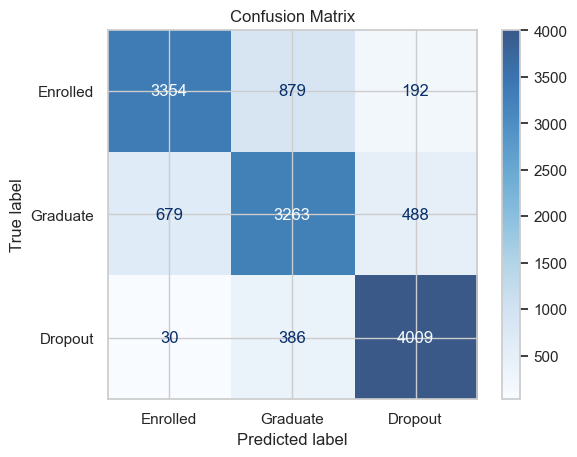

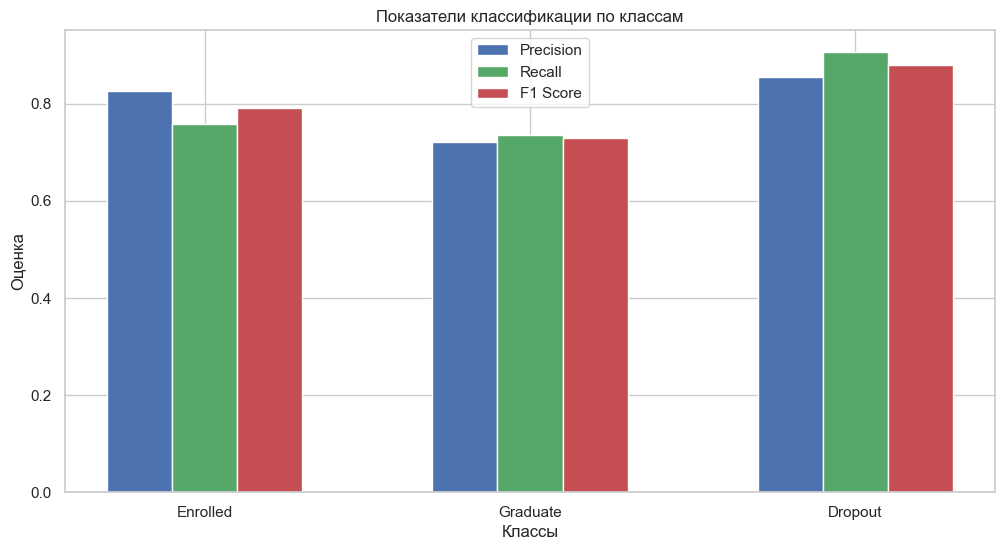

Accuracy of xgboost: 0.8588
Classification Report for xgboost:
              precision    recall  f1-score   support

    Enrolled       0.90      0.86      0.88      4425
    Graduate       0.81      0.81      0.81      4430
     Dropout       0.86      0.91      0.88      4425

    accuracy                           0.86     13280
   macro avg       0.86      0.86      0.86     13280
weighted avg       0.86      0.86      0.86     13280



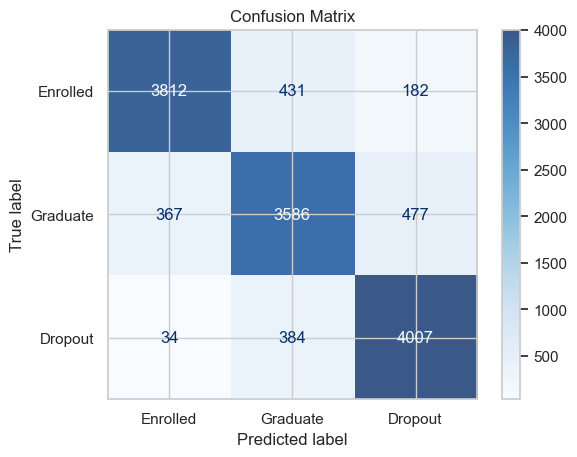

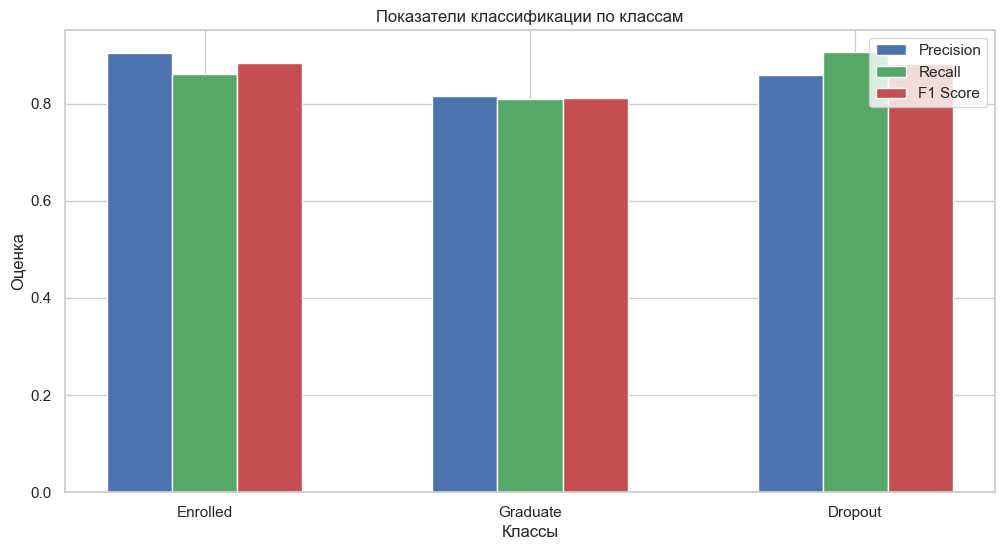

Accuracy of randomforest: 0.7646
Classification Report for randomforest:
              precision    recall  f1-score   support

    Enrolled       0.80      0.69      0.74      4425
    Graduate       0.66      0.71      0.69      4430
     Dropout       0.83      0.89      0.86      4425

    accuracy                           0.76     13280
   macro avg       0.77      0.76      0.76     13280
weighted avg       0.77      0.76      0.76     13280



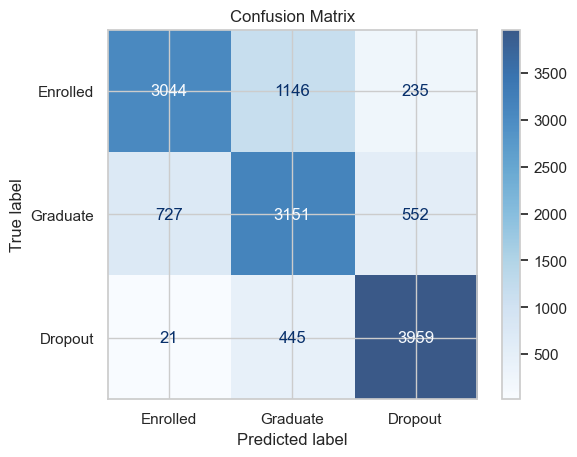

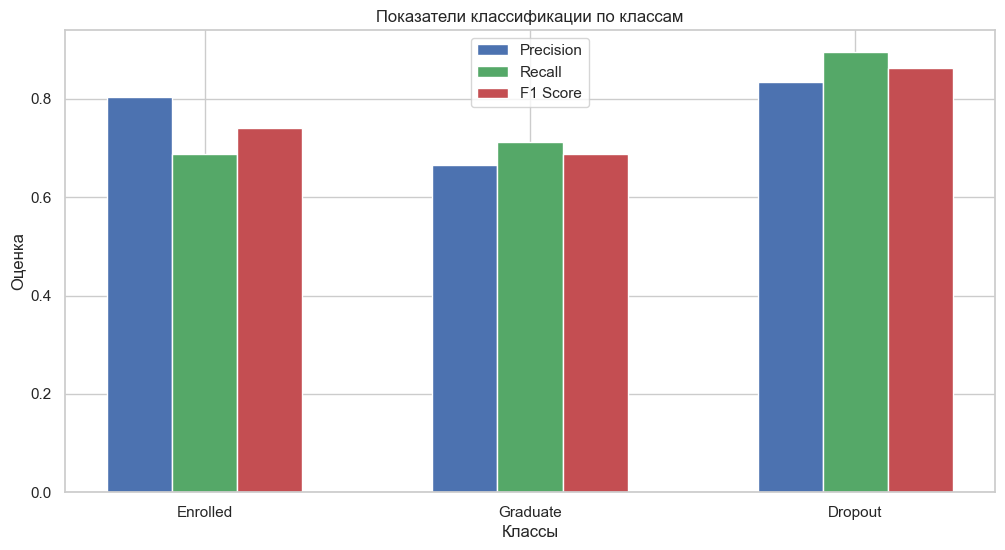

In [106]:
fit_stacking_classifier(X_train, y_train, X_test, y_test)

# Сравнимые результаты были показаны на данных, очищенных от выбросов.

Classification Report for StackingClassifier:
              precision    recall  f1-score   support

    Enrolled       0.91      0.88      0.89      4425
    Graduate       0.83      0.82      0.82      4430
     Dropout       0.86      0.91      0.88      4425

    accuracy                           0.87     13280
   macro avg       0.87      0.87      0.87     13280
weighted avg       0.87      0.87      0.87     13280

StackingClassifier Accuracy: 0.8672
Accuracy of catboost: 0.8002
Classification Report for catboost:
              precision    recall  f1-score   support

    Enrolled       0.83      0.76      0.79      4425
    Graduate       0.72      0.74      0.73      4430
     Dropout       0.85      0.91      0.88      4425

    accuracy                           0.80     13280
   macro avg       0.80      0.80      0.80     13280
weighted avg       0.80      0.80      0.80     13280



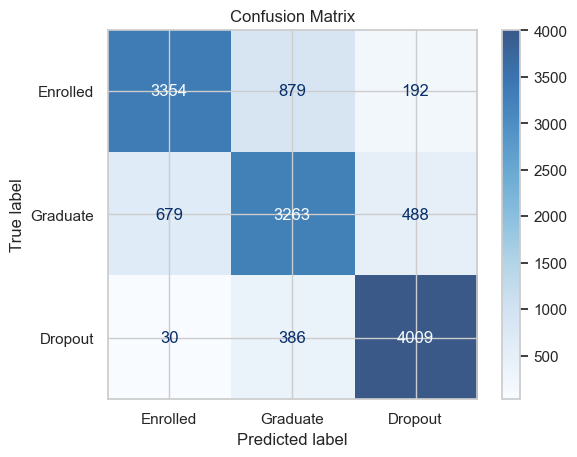

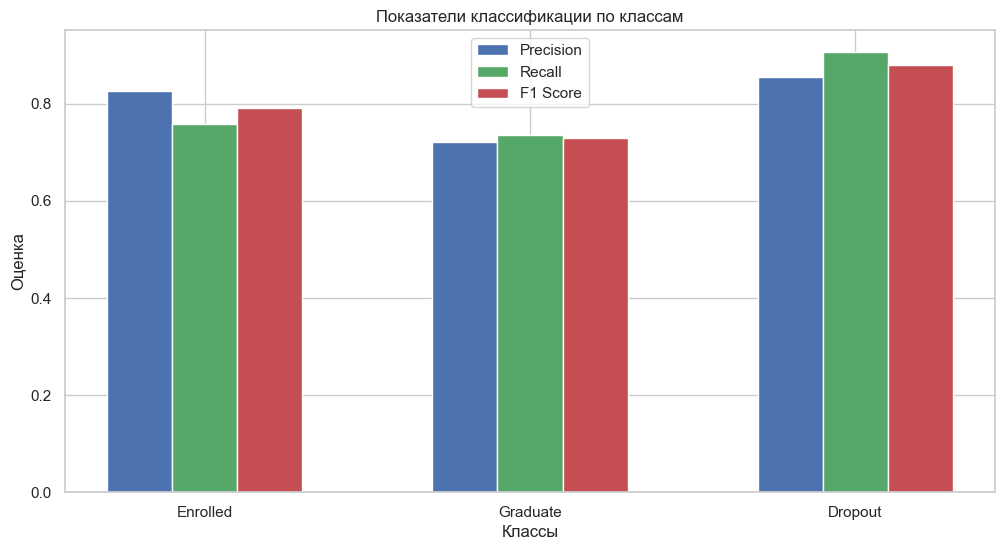

Accuracy of xgboost: 0.8588
Classification Report for xgboost:
              precision    recall  f1-score   support

    Enrolled       0.90      0.86      0.88      4425
    Graduate       0.81      0.81      0.81      4430
     Dropout       0.86      0.91      0.88      4425

    accuracy                           0.86     13280
   macro avg       0.86      0.86      0.86     13280
weighted avg       0.86      0.86      0.86     13280



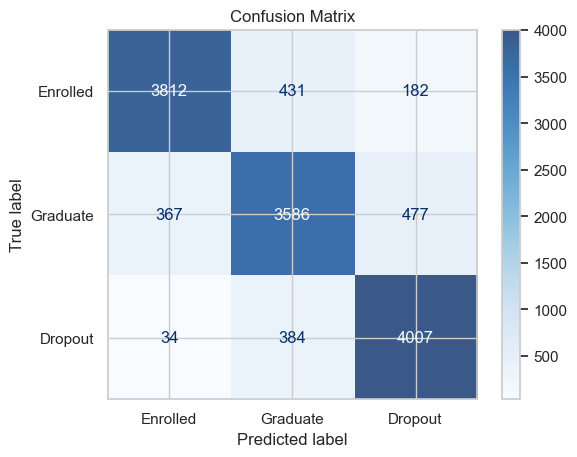

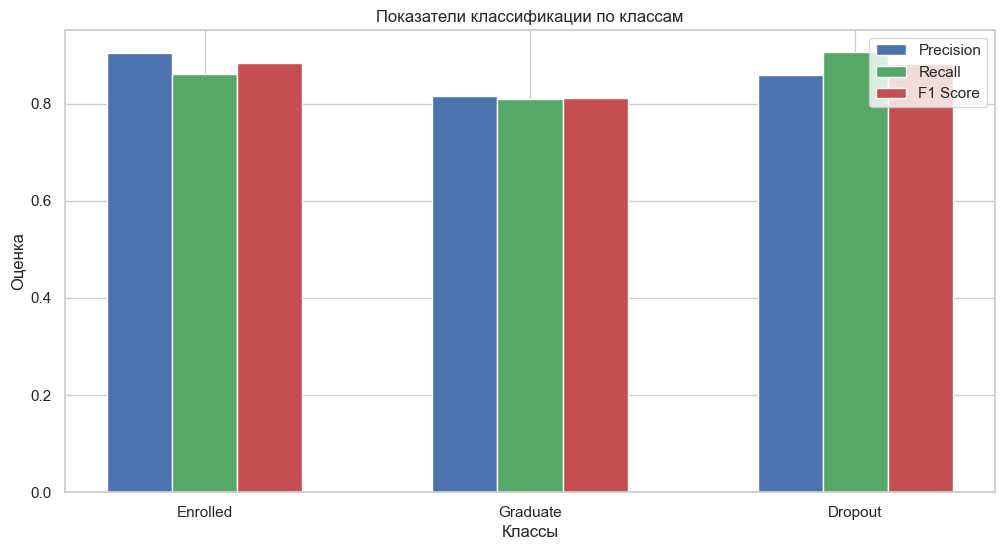

Accuracy of randomforest: 0.7628
Classification Report for randomforest:
              precision    recall  f1-score   support

    Enrolled       0.80      0.68      0.74      4425
    Graduate       0.66      0.71      0.68      4430
     Dropout       0.83      0.90      0.86      4425

    accuracy                           0.76     13280
   macro avg       0.77      0.76      0.76     13280
weighted avg       0.77      0.76      0.76     13280



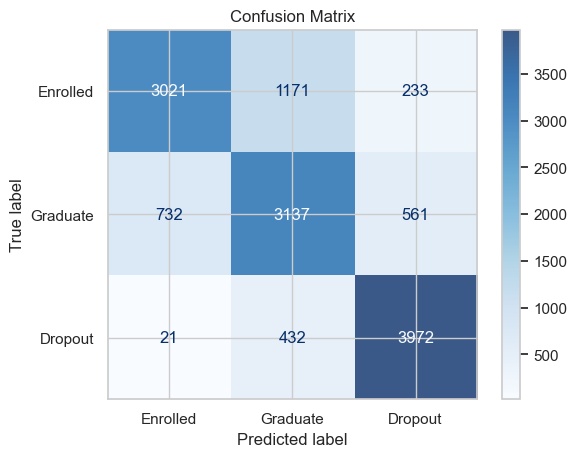

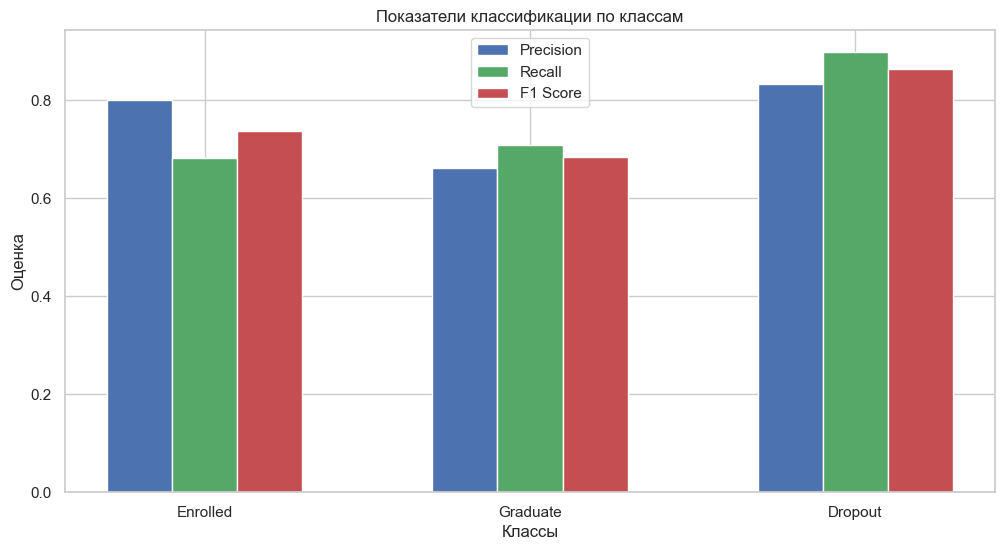

In [105]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

# Подготовка данных
X = filtered_train.drop('Target', axis=1)
y = filtered_train['Target']

# Применение SMOTE для устранения дисбаланса классов
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42
)

fit_stacking_classifier(X_train, y_train, X_test, y_test)